[View in Colaboratory](https://colab.research.google.com/github/connected-bsamadi/colab-notebooks/blob/master/Bag_of_Words_Model_Multiclass_Classification.ipynb)

# Intro to text classification with Keras: automatically tagging Stack Overflow posts
Reference: [Google Cloud Blog](https://cloud.google.com/blog/products/gcp/intro-to-text-classification-with-keras-automatically-tagging-stack-overflow-posts)

# Initialization

In [0]:
# Google Cloud authentication
from google.colab import auth
auth.authenticate_user()

In [0]:
# Assigning the project name and creating the BigQuery client
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'ontario-2018'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import time
import itertools
from concurrent import futures

from google.cloud import bigquery

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.preprocessing import text, sequence
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


# Data Query

In [0]:
client = bigquery.Client(project=project_id)

In [0]:
query = (r'''
# This query will get 2000 SO posts for the top 20 tags to be fed into our Keras model 
# Here we're only selecting posts with a single tag to keep things simple
# The regex preprocesses the text (strips newlines, commas, and <p> tags), this makes it easier for our model to interpret the text
# We're using partitioning to control the number of posts we get for each tag

SELECT post, tags FROM (
  SELECT 
    TRIM(LOWER(REGEXP_REPLACE(CONCAT(title, ' ', body), r'["\n\'?,]|<p>|</p>'," "))) as post,
    tags,
    row_number() over(partition by tags) row_num
  FROM `bigquery-public-data.stackoverflow.posts_questions` a
  WHERE tags IN ("javascript", "java", "c#", "php", "android", "jquery", "python", "html", "c++", "ios", "css", "mysql", "sql", "asp.net", "ruby-on-rails", "objective-c", "c", ".net", "angularjs", "iphone")
)
WHERE row_num <= 2000
ORDER BY RAND()
''')
query_job = client.query(query)

In [6]:
data = query_job.to_dataframe()
data.head()

,post,tags
0,environment.failfast in a web context does a ...,.net
1,how to access object from another form c# so ...,c#
2,how can i get rid of putting new before a fu...,javascript
3,how to get access token refreshed from faceboo...,c#
4,how to set $cmd overtime in php <pre><code>&l...,php


In [7]:
# Confirm that we have a balanced dataset
# Note: data was randomly shuffled in our BigQuery query
data['tags'].value_counts()

python           2000
asp.net          2000
css              2000
angularjs        2000
c#               2000
javascript       2000
ruby-on-rails    2000
ios              2000
php              2000
c                2000
android          2000
.net             2000
jquery           2000
objective-c      2000
html             2000
sql              2000
iphone           2000
java             2000
mysql            2000
c++              2000
Name: tags, dtype: int64

In [8]:
# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 32000
Test size: 8000


In [0]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [14]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (32000, 1000)
x_test shape: (8000, 1000)
y_train shape: (32000, 20)
y_test shape: (8000, 20)


In [0]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

In [0]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 28800 samples, validate on 3200 samples
Epoch 1/2
28800/28800 [==============================] - 10s 361us/step - loss: 0.9854 - acc: 0.7139 - val_loss: 0.6181 - val_acc: 0.8053
Epoch 2/2
28800/28800 [==============================] - 10s 352us/step - loss: 0.5537 - acc: 0.8235 - val_loss: 0.5960 - val_acc: 0.8056


In [18]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8000/8000 [==============================] - 1s 72us/step
Test score: 0.5863786768317223
Test accuracy: 0.813375


In [19]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

for eaching into a class s members  is there a way ...
Actual label:.net
Predicted label: .net

how to run command sqlloader oracle in c#  how to  ...
Actual label:c#
Predicted label: c#

static dataset shared on iis  i have a static data ...
Actual label:asp.net
Predicted label: asp.net

sql wont let me replace a quote in select statemen ...
Actual label:sql
Predicted label: sql

newline in <td title=  > <blockquote>    <strong>p ...
Actual label:html
Predicted label: html

how would i go about getting a breakdown (and sum  ...
Actual label:mysql
Predicted label: sql

how to randomize all the entire content inside of  ...
Actual label:c#
Predicted label: php

is there a python module that provides deeper anal ...
Actual label:python
Predicted label: python

i want to take a photo when app in the background  ...
Actual label:ios
Predicted label: ios

do while with two double type variable  i want to  ...
Actual label:c
Predicted label: c



In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

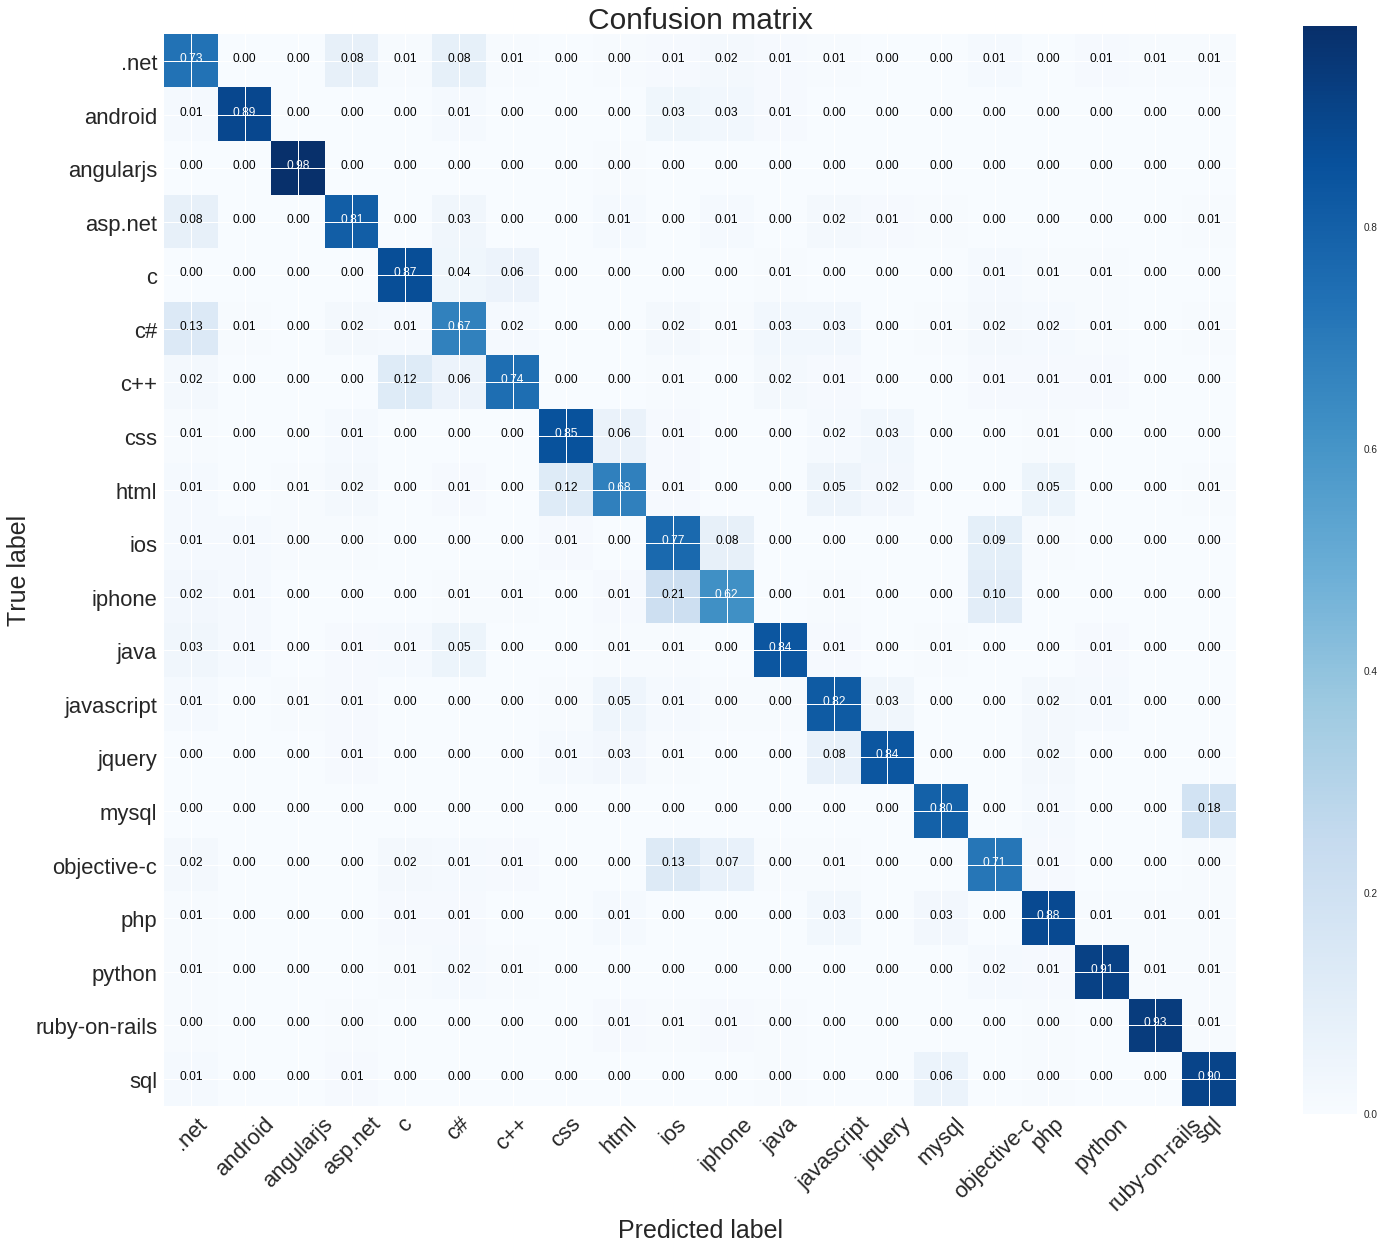

In [22]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()